0. Imports

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


1. Load data

In [34]:
# Load datasets
sentiment = pd.read_csv("/content/fear_greed_index.csv")
trades = pd.read_excel("/content/historical_data.xlsx")

2. Basic data checks (Part A)

In [35]:
def data_summary(df):
    return {
        "rows": df.shape[0],
        "columns": df.shape[1],
        "missing_values": df.isna().sum().sum(),
        "duplicates": df.duplicated().sum()
    }

print("Sentiment:", data_summary(sentiment))
print("Trades:", data_summary(trades))


Sentiment: {'rows': 2644, 'columns': 4, 'missing_values': np.int64(0), 'duplicates': np.int64(0)}
Trades: {'rows': 211224, 'columns': 16, 'missing_values': np.int64(0), 'duplicates': np.int64(0)}


3. Time conversion & alignment

In [36]:
# Convert sentiment date
sentiment["date"] = pd.to_datetime(sentiment["date"])

# Convert trade timestamp
trades["date"] = pd.to_datetime(trades["Timestamp"], unit="ms").dt.date
trades["date"] = pd.to_datetime(trades["date"])

# Merge sentiment onto trades
df = trades.merge(
    sentiment[["date", "classification"]],
    on="date",
    how="left"
)

df["classification"].value_counts()


,count
classification,
Fear,133871
Greed,36289
Neutral,7141
Extreme Greed,6962


4. Feature engineering (daily trader metrics)

In [37]:
daily_trader = (
    df.groupby(["Account", "date", "classification"])
      .agg(
          daily_pnl=("Closed PnL", "sum"),
          trades_per_day=("Trade ID", "count"),
          avg_trade_size=("Size USD", "mean"),
          long_ratio=("Side", lambda x: (x == "BUY").mean())
      )
      .reset_index()
)

daily_trader.head()


,Account,date,classification,daily_pnl,trades_per_day,avg_trade_size,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,Greed,-3.275059e+05,462,14810.891818,0.300866
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,Fear,1.927736e+06,3356,16345.241940,0.468415
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,Greed,2.060745e+04,320,2492.749906,0.453125
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,Fear,1.709873e+04,3533,1693.351684,0.432494
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,Neutral,-1.000000e+00,5,6070.200000,0.400000


5. Performance vs Sentiment (Part B – Q1)

In [38]:
pnl_by_sentiment = (
    daily_trader
    .groupby("classification")["daily_pnl"]
    .describe()
)

pnl_by_sentiment


,count,mean,std,min,25%,50%,75%,max
classification,,,,,,,,
Extreme Greed,5.0,35393.098355,85325.499902,-7919.471032,-5564.016140,0.000000,2606.894756,1.878421e+05
Fear,32.0,209372.662205,380423.906864,-59349.677108,21140.798004,81389.682515,203219.937358,1.927736e+06
Greed,32.0,99675.516731,282694.285526,-327505.900056,1383.746000,35988.376437,68245.792919,1.421756e+06
Neutral,8.0,19842.797260,57227.787895,-25991.506339,-10470.244431,-0.418640,15808.361499,1.455634e+05


Plot: Daily PnL distribution

<Figure size 640x480 with 0 Axes>

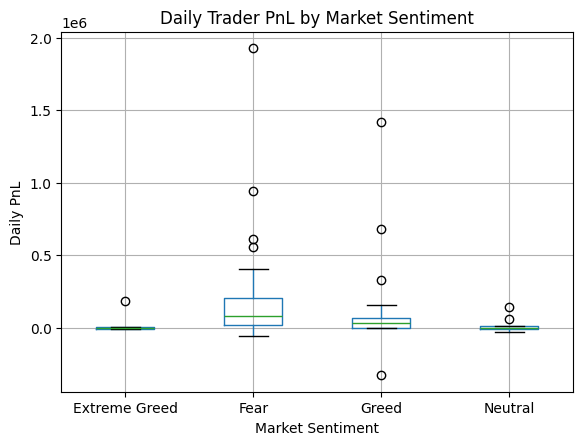

In [39]:
plt.figure()
daily_trader.boxplot(column="daily_pnl", by="classification")
plt.title("Daily Trader PnL by Market Sentiment")
plt.suptitle("")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.show()


6. Behavioral changes vs sentiment (Part B – Q2)

In [40]:
freq_by_sentiment = (
    daily_trader
    .groupby("classification")["trades_per_day"]
    .mean()
)

freq_by_sentiment


,trades_per_day
classification,
Extreme Greed,1392.40000
Fear,4183.46875
Greed,1134.03125
Neutral,892.62500


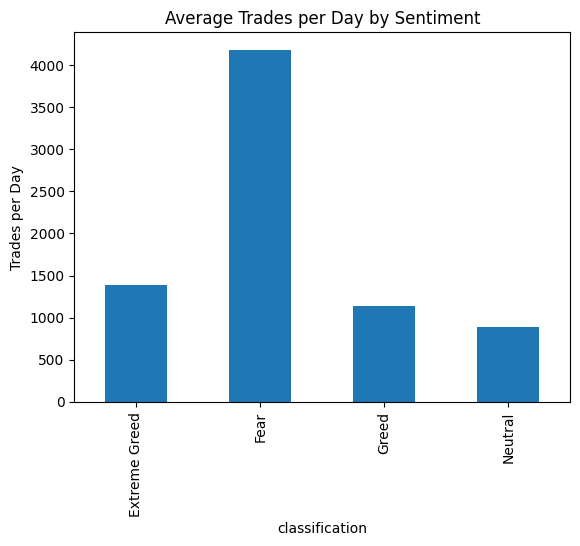

In [41]:
plt.figure()
freq_by_sentiment.plot(kind="bar")
plt.title("Average Trades per Day by Sentiment")
plt.ylabel("Trades per Day")
plt.show()


Position bias (long/short)

In [42]:
long_ratio_by_sentiment = (
    daily_trader
    .groupby("classification")["long_ratio"]
    .mean()
)

long_ratio_by_sentiment


,long_ratio
classification,
Extreme Greed,0.518479
Fear,0.459352
Greed,0.495780
Neutral,0.468967


7. Trader segmentation (Part B – Q3)

In [43]:
activity = (
    daily_trader.groupby("Account")["trades_per_day"]
    .mean()
    .reset_index(name="avg_trades")
)

threshold = activity["avg_trades"].median()

activity["segment"] = np.where(
    activity["avg_trades"] >= threshold,
    "Frequent Traders",
    "Infrequent Traders"
)

segmented = daily_trader.merge(activity[["Account", "segment"]], on="Account")


In [44]:
segment_perf = (
    segmented
    .groupby(["segment", "classification"])["daily_pnl"]
    .mean()
    .reset_index()
)

segment_perf


,segment,classification,daily_pnl
0,Frequent Traders,Extreme Greed,60843.169305
1,Frequent Traders,Fear,324428.018469
2,Frequent Traders,Greed,158438.794314
3,Frequent Traders,Neutral,6867.420164
4,Infrequent Traders,Extreme Greed,-2782.008070
5,Infrequent Traders,Fear,94317.305942
6,Infrequent Traders,Greed,47825.565921
7,Infrequent Traders,Neutral,32818.174355


8. Simple win-rate proxy

In [45]:
daily_trader["win"] = daily_trader["daily_pnl"] > 0

win_rate = (
    daily_trader
    .groupby("classification")["win"]
    .mean()
)

win_rate


,win
classification,
Extreme Greed,0.40000
Fear,0.93750
Greed,0.84375
Neutral,0.50000


9. Tables to include in submission

In [46]:
summary_table = (
    daily_trader
    .groupby("classification")
    .agg(
        avg_pnl=("daily_pnl", "mean"),
        pnl_std=("daily_pnl", "std"),
        win_rate=("win", "mean"),
        avg_trades=("trades_per_day", "mean")
    )
)

summary_table


,avg_pnl,pnl_std,win_rate,avg_trades
classification,,,,
Extreme Greed,35393.098355,85325.499902,0.40000,1392.40000
Fear,209372.662205,380423.906864,0.93750,4183.46875
Greed,99675.516731,282694.285526,0.84375,1134.03125
Neutral,19842.797260,57227.787895,0.50000,892.62500


10. (Optional Bonus) Simple predictive model

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model_df = daily_trader.dropna().copy()

X = model_df[["trades_per_day", "avg_trade_size", "long_ratio"]]
y = model_df["win"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      1.00      0.86        18

    accuracy                           0.75        24
   macro avg       0.38      0.50      0.43        24
weighted avg       0.56      0.75      0.64        24



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
